In [1]:
print("hello")

hello


Loading data from hidden_states_ALL_LAYERS.pt...
Preprocessing & Normalizing...
Total Features: 103936 (33 layers * 3584 dims)

Starting Lasso Training...
Epoch 1 | Loss: 3.3219 | Sparsity (Zero ratio): 98.01%
Epoch 6 | Loss: 1.1824 | Sparsity (Zero ratio): 99.61%
Epoch 11 | Loss: 1.1424 | Sparsity (Zero ratio): 99.73%
Epoch 16 | Loss: 1.1472 | Sparsity (Zero ratio): 99.70%
Epoch 20 | Loss: 1.1432 | Sparsity (Zero ratio): 99.72%

Analyzing Weights...


/tmp/ipykernel_446099/1506910442.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(layer_importance)), y=layer_importance, palette=colors)


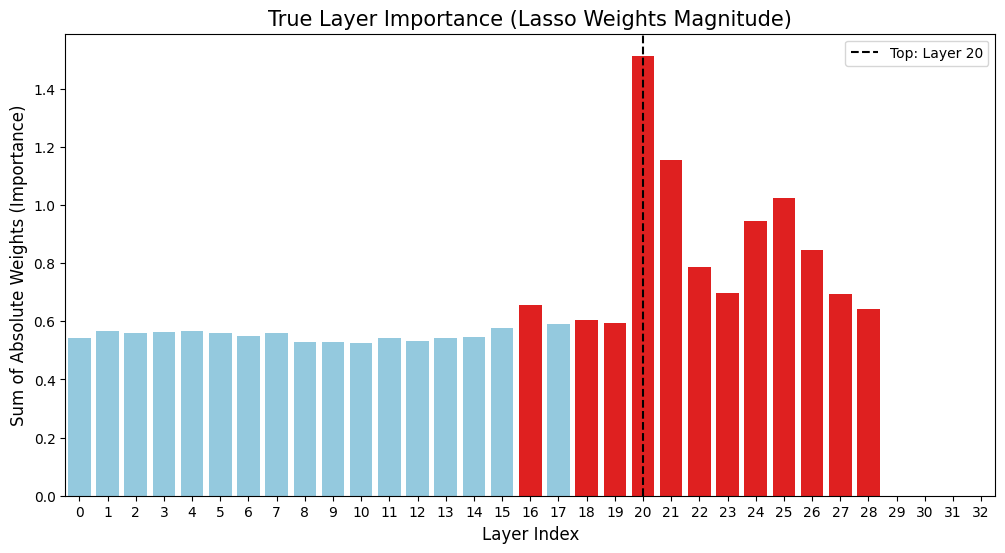


最も重要な層: 第 20 層


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. データ読み込み & 正規化 (重要!)
# ==========================================
DATA_PATH = "hidden_states_ALL_LAYERS.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LAMBDA_L1 = 0.05  # 強めの正則化

print(f"Loading data from {DATA_PATH}...")
raw_data = torch.load(DATA_PATH)

X_list = []
Y_list = []

print("Preprocessing & Normalizing...")
for item in raw_data:
    # [33, Seq, Dim] -> [Seq, 33*Dim] (Flatten)
    # ここで層×次元を一列に並べる
    h_c = item['creative'].permute(1, 0, 2).reshape(item['creative'].shape[1], -1).float()
    h_n = item['normal'].permute(1, 0, 2).reshape(item['normal'].shape[1], -1).float()
    
    X_list.append(h_c)
    Y_list.append(torch.ones(h_c.shape[0]))
    X_list.append(h_n)
    Y_list.append(torch.zeros(h_n.shape[0]))

X_all = torch.cat(X_list, dim=0) # [Total_Samples, Features]
Y_all = torch.cat(Y_list, dim=0).unsqueeze(1) # [Total_Samples, 1]

# ★重要: スケーリング (層ごとの値の大きさの違いを吸収する)
# これをやらないと、値が大きいだけの層が「重要」と誤解される
scaler = StandardScaler()
# CPUで計算 (GPUだとメモリあふれる可能性あるため)
X_numpy = X_all.numpy()
X_scaled = scaler.fit_transform(X_numpy)
X_all = torch.tensor(X_scaled, dtype=torch.float32)

dataset = TensorDataset(X_all, Y_all)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total Features: {X_all.shape[1]} (33 layers * 3584 dims)")

# ==========================================
# 2. Lasso Probe (シンプルな線形層)
# ==========================================
class LassoProbe(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
    
    def forward(self, x):
        return self.linear(x)

model = LassoProbe(X_all.shape[1]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# ==========================================
# 3. 学習 (L1正則化を直接重みにかける)
# ==========================================
print("\nStarting Lasso Training...")

for epoch in range(20): # 収束は早いはず
    model.train()
    total_loss = 0
    
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(DEVICE), batch_Y.to(DEVICE)
        
        optimizer.zero_grad()
        logits = model(batch_X)
        bce_loss = criterion(logits, batch_Y)
        
        # L1 Regularization on Weights directly
        # 重みの絶対値の合計をLossに足す -> 重みが0に近づく
        l1_loss = LAMBDA_L1 * torch.norm(model.linear.weight, 1)
        
        loss = bce_loss + l1_loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    if epoch % 5 == 0 or epoch == 19:
        # 重みがほぼ0になっている変数の割合
        zero_weights = (torch.abs(model.linear.weight) < 1e-3).float().mean().item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Sparsity (Zero ratio): {zero_weights:.2%}")

# ==========================================
# 4. 結果の解析 (重みの絶対値を集計)
# ==========================================
print("\nAnalyzing Weights...")
model.eval()
weights = torch.abs(model.linear.weight.detach().cpu()).squeeze(0).numpy() # [33*3584]

# 層ごとに分割して集計
# weights は [L0_D0, L0_D1, ..., L0_Dlast, L1_D0, ...] の順に並んでいる
num_layers = 33 # Qwenの層数 (Embedding含むなら+1だが通常は0-32)
input_dim = 3584 # Qwenの次元数

layer_importance = []
for i in range(num_layers):
    # スライスして合計
    start_idx = i * input_dim
    end_idx = (i + 1) * input_dim
    # その層の重みの合計（＝重要度）
    layer_score = weights[start_idx:end_idx].sum()
    layer_importance.append(layer_score)

# --- グラフ描画 ---
layer_importance = np.array(layer_importance)
plt.figure(figsize=(12, 6))
# 色分け: 平均より高いところを目立たせる
colors = ['red' if x > np.mean(layer_importance) else 'skyblue' for x in layer_importance]

sns.barplot(x=np.arange(len(layer_importance)), y=layer_importance, palette=colors)
plt.title("True Layer Importance (Lasso Weights Magnitude)", fontsize=15)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Sum of Absolute Weights (Importance)", fontsize=12)

best_layer = np.argmax(layer_importance)
plt.axvline(best_layer, color='black', linestyle='--', label=f"Top: Layer {best_layer}")
plt.legend()
plt.show()

print(f"\n最も重要な層: 第 {best_layer} 層")

Loading diverse data from hidden_states_ALL_LAYERS_DIVERSE.pt...
Preprocessing & Normalizing (Diverse Data)...
Training Lasso on 7890 tokens to find 'Universal Creativity'...
Epoch 0: Loss 2.6585 | Sparsity 98.42%
Epoch 5: Loss 1.7289 | Sparsity 98.80%
Epoch 10: Loss 1.6939 | Sparsity 99.05%

Identifying the 'Universal Creativity Layer'...
🏆 Best Layer: 21 (Score: 1.81)


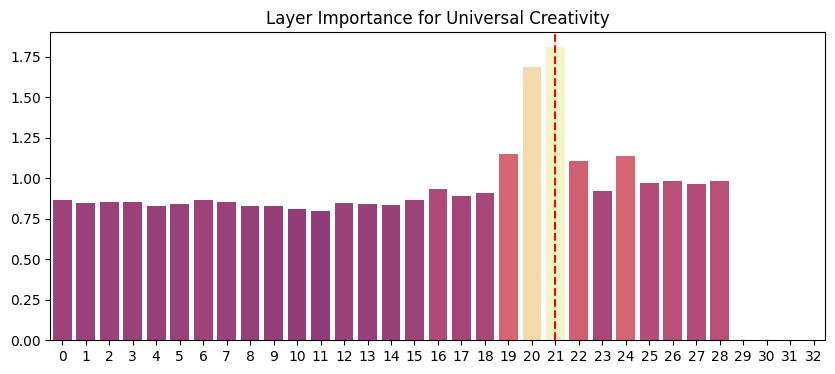


Loading Model for Verification...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


========== TEST: Scientific Domain ==========
Prompt: Propose a new scientific theory about the relationship between time and consciousness.

--- Normal ---
 The theory should include the following key elements: 1. A definition of
consciousness 2. A description of how time is related to consciousness 3. An
explanation of how this relationship affects our perception of reality 4. A
hypothesis about how altering our perception of time could impact our
consciousness 5. A prediction based on this hypothesis  Definition of
consciousness: Consciousness can be defined as the state of being aware of one's
own existence, thoughts, emotions, and surroundings. It involves the ability to

--- Steered (Universal) ---
 One potential new scientific theory about the relationship between time and
consciousness could be that time is not an objective, external reality, but
rather a subjective experience that arises from the way our consciousness
perceives events and their relationships to one another.  

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModelForCausalLM

# ==========================================
# 設定
# ==========================================
DATA_PATH = "hidden_states_ALL_LAYERS_DIVERSE.pt" # さっき作った多様なデータ
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LAMBDA_L1 = 0.05  # 正則化係数

# ==========================================
# 1. データの読み込みとLasso学習
# ==========================================
print(f"Loading diverse data from {DATA_PATH}...")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Please run the data collection code first.")

raw_data = torch.load(DATA_PATH)

X_list = []
Y_list = []

print("Preprocessing & Normalizing (Diverse Data)...")
# 多様なSystem Promptごとのデータが混ざっている状態
for item in raw_data:
    # [33, Seq, Dim] -> Flatten -> [Seq, Features]
    h_c = item['creative'].permute(1, 0, 2).reshape(item['creative'].shape[1], -1).float()
    h_n = item['normal'].permute(1, 0, 2).reshape(item['normal'].shape[1], -1).float()
    
    X_list.append(h_c)
    Y_list.append(torch.ones(h_c.shape[0])) # 1 = Any Creative (Sci, Art, Phil...)
    X_list.append(h_n)
    Y_list.append(torch.zeros(h_n.shape[0])) # 0 = Any Normal

X_all = torch.cat(X_list, dim=0)
Y_all = torch.cat(Y_list, dim=0).unsqueeze(1)

# スケーリング (重要: 異なるドメインの特徴量を混ぜるため正規化が必須)
scaler = StandardScaler()
X_numpy = X_all.numpy()
X_scaled = scaler.fit_transform(X_numpy)
X_all = torch.tensor(X_scaled, dtype=torch.float32)

dataset = TensorDataset(X_all, Y_all)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Lassoモデル定義
class LassoProbe(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
    def forward(self, x):
        return self.linear(x)

print(f"Training Lasso on {X_all.shape[0]} tokens to find 'Universal Creativity'...")
probe = LassoProbe(X_all.shape[1]).to(DEVICE)
optimizer = optim.Adam(probe.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# 学習ループ
for epoch in range(15):
    probe.train()
    total_loss = 0
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(DEVICE), batch_Y.to(DEVICE)
        optimizer.zero_grad()
        logits = probe(batch_X)
        bce_loss = criterion(logits, batch_Y)
        l1_loss = LAMBDA_L1 * torch.norm(probe.linear.weight, 1) # L1正則化
        loss = bce_loss + l1_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 5 == 0:
        zero_ratio = (torch.abs(probe.linear.weight) < 1e-3).float().mean().item()
        print(f"Epoch {epoch}: Loss {total_loss/len(train_loader):.4f} | Sparsity {zero_ratio:.2%}")

# ==========================================
# 2. 最重要層の特定とベクトル抽出
# ==========================================
print("\nIdentifying the 'Universal Creativity Layer'...")
probe.eval()
weights = torch.abs(probe.linear.weight.detach().cpu()).squeeze(0).numpy()

num_layers = 33
input_dim = 3584
layer_scores = []

for i in range(num_layers):
    score = weights[i*input_dim : (i+1)*input_dim].sum()
    layer_scores.append(score)

best_layer = np.argmax(layer_scores)
print(f"🏆 Best Layer: {best_layer} (Score: {layer_scores[best_layer]:.2f})")

# グラフ表示
plt.figure(figsize=(10, 4))
sns.barplot(x=np.arange(num_layers), y=layer_scores, hue=layer_scores, palette="magma", legend=False)
plt.title("Layer Importance for Universal Creativity")
plt.axvline(best_layer, color='red', linestyle='--')
plt.show()

# ベクトル抽出
start_idx = best_layer * input_dim
end_idx = (best_layer + 1) * input_dim
universal_vector = probe.linear.weight.detach().cpu().squeeze(0)[start_idx:end_idx]
universal_vector = universal_vector.to(DEVICE).float()
# 正規化
universal_vector = universal_vector / torch.norm(universal_vector)

# ==========================================
# 3. 汎用性の検証 (Inference Test)
# ==========================================
print(f"\nLoading Model for Verification...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_gen = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")

# 介入強度 (前回の20.0は強すぎたのでマイルドにする)
STEERING_STRENGTH = 10.0 

# Hook関数
def steering_hook(module, input, output):
    if isinstance(output, tuple):
        hidden_states = output[0]
    else:
        hidden_states = output
    
    vec = universal_vector.to(hidden_states.device)
    
    if hidden_states.dim() == 3:
        hidden_states[:, :, :] += STEERING_STRENGTH * vec
    elif hidden_states.dim() == 2:
        hidden_states[:, :] += STEERING_STRENGTH * vec
    
    return output

def run_test(prompt, title):
    print(f"\n{'='*10} TEST: {title} {'='*10}")
    print(f"Prompt: {prompt}")
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    # Normal
    with torch.no_grad():
        out_n = model_gen.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.7)
    text_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):]
    
    # Steered
    layer_module = model_gen.model.layers[best_layer]
    handle = layer_module.register_forward_hook(steering_hook)
    try:
        with torch.no_grad():
            out_s = model_gen.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.7)
    finally:
        handle.remove()
    text_s = tokenizer.decode(out_s[0], skip_special_tokens=True)[len(prompt):]
    
    print(f"\n--- Normal ---\n{textwrap.fill(text_n, width=80)}")
    print(f"\n--- Steered (Universal) ---\n{textwrap.fill(text_s, width=80)}")

# 検証A: 科学的なお題 (論理が崩壊せず、かつ独創的か？)
run_test(
    "Propose a new scientific theory about the relationship between time and consciousness.", 
    "Scientific Domain"
)

# 検証B: 芸術的なお題 (前回のように詩的になるか？)
run_test(
    "Write a short poem about a clock that runs backwards.", 
    "Artistic Domain"
)

In [4]:
# import torch
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# from transformers import AutoTokenizer, AutoModelForCausalLM

# # ==========================================
# # 設定
# # ==========================================
# MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# STEERING_STRENGTH = 10.0 # 検証したい強度
# TARGET_LAYER = best_layer # さっき特定した層 (例: 21)
# VECTOR = universal_vector # さっき抽出したベクトル

# # ==========================================
# # 1. 大量のお題生成 (4つのドメイン)
# # ==========================================
# domains = {
#     "Science": [
#         "Explain the concept of entropy.", "Propose a new energy source.", 
#         "Describe the edge of the universe.", "What is consciousness?",
#         "Theory of everything.", "Future of evolution.", "Quantum biology.",
#         "The sound of a black hole.", "Time travel paradox.", "Artificial life."
#     ],
#     "Art": [
#         "A poem about a broken mirror.", "Describe a color that doesn't exist.",
#         "A story about a lonely cloud.", "The taste of nostalgia.",
#         "Music of the spheres.", "A painting of silence.", "Dancing shadows.",
#         "The smell of moonlight.", "Whispers of the forest.", "Statue that cries."
#     ],
#     "Business": [
#         "A slogan for a flying car.", "Sell ice to an eskimo.",
#         "Future of remote work.", "A startup idea involving dreams.",
#         "Marketing strategy for silence.", "Economy of Mars.", "Crypto for pets.",
#         "Leadership in chaos.", "Selling emotions.", "Insurance for time travelers."
#     ],
#     "Philosophy": [
#         "Is free will real?", "Meaning of life in one sentence.",
#         "Simulated reality hypothesis.", "Ethics of immortality.",
#         "The sound of one hand clapping.", "Do numbers exist?", "Nature of truth.",
#         "Can a machine feel pain?", "The ship of Theseus.", "Happiness vs Meaning."
#     ]
# }

# # プロンプトリストを拡張 (各ドメインを増幅して100件以上にする)
# all_prompts = []
# for domain, prompts in domains.items():
#     for p in prompts:
#         all_prompts.append({"domain": domain, "text": p})
#         # 少し表現を変えてデータ数を水増し（ロバスト性チェックのため）
#         all_prompts.append({"domain": domain, "text": f"Write about: {p}"})
#         all_prompts.append({"domain": domain, "text": f"Deeply analyze: {p}"})

# print(f"Total Prompts for Verification: {len(all_prompts)}")

# # ==========================================
# # 2. メトリクス計算関数
# # ==========================================
# def calculate_metrics(text, prompt_text, model, tokenizer):
#     # 1. Lexical Diversity (TTR: Type-Token Ratio)
#     tokens = tokenizer.tokenize(text)
#     if len(tokens) == 0: return 0, 0
#     ttr = len(set(tokens)) / len(tokens)
    
#     # 2. Semantic Distance (簡易版: 自身のEmbeddingを使用)
#     # 外部モデルを使わず、現在のモデルの最終層の平均プーリングで代用
#     with torch.no_grad():
#         inputs = tokenizer([prompt_text, text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
#         outputs = model(**inputs, output_hidden_states=True)
#         # 最終層のHidden State [2, Seq, Dim]
#         last_hidden = outputs.hidden_states[-1]
#         # Mean Pooling (Attention Mask考慮)
#         mask = inputs.attention_mask.unsqueeze(-1)
#         embeddings = (last_hidden * mask).sum(dim=1) / mask.sum(dim=1)
        
#         # Cosine Similarity
#         sim = F.cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0)).item()
#         distance = 1.0 - sim # 距離 (0=同じ, 2=正反対)
        
#     return ttr, distance

# # ==========================================
# # 3. ベンチマーク実行ループ
# # ==========================================
# results = []

# print("Running Massive Benchmark (This may take a while)...")

# # モデルロード (Hook用にGlobal変数にする)
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model_gen = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
# model_gen.eval()

# # Hook定義
# def steering_hook(module, input, output):
#     if isinstance(output, tuple):
#         h = output[0]
#     else:
#         h = output
    
#     vec = VECTOR.to(h.device)
#     if h.dim() == 3: h[:, :, :] += STEERING_STRENGTH * vec
#     elif h.dim() == 2: h[:, :] += STEERING_STRENGTH * vec
#     return output

# for item in tqdm(all_prompts):
#     prompt = item["text"]
#     domain = item["domain"]
#     inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
#     # --- A. Normal Run ---
#     with torch.no_grad():
#         out_n = model_gen.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.7)
#     text_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):]
    
#     ttr_n, dist_n = calculate_metrics(text_n, prompt, model_gen, tokenizer)
    
#     results.append({
#         "Type": "Normal",
#         "Domain": domain,
#         "TTR (Richness)": ttr_n,
#         "Semantic Dist (Novelty)": dist_n,
#         "Length": len(text_n)
#     })
    
#     # --- B. Steered Run ---
#     layer_module = model_gen.model.layers[TARGET_LAYER]
#     handle = layer_module.register_forward_hook(steering_hook)
#     try:
#         with torch.no_grad():
#             out_s = model_gen.generate(**inputs, max_new_tokens=80, do_sample=True, temperature=0.7)
#     except:
#         # エラー時はスキップ
#         handle.remove()
#         continue
        
#     handle.remove()
#     text_s = tokenizer.decode(out_s[0], skip_special_tokens=True)[len(prompt):]
    
#     ttr_s, dist_s = calculate_metrics(text_s, prompt, model_gen, tokenizer)
    
#     results.append({
#         "Type": "Steered",
#         "Domain": domain,
#         "TTR (Richness)": ttr_s,
#         "Semantic Dist (Novelty)": dist_s,
#         "Length": len(text_s)
#     })

# # ==========================================
# # 4. 結果の可視化と統計検定
# # ==========================================
# df = pd.DataFrame(results)

# # グラフ描画
# plt.figure(figsize=(14, 6))

# # 1. 語彙の多様性 (TTR)
# plt.subplot(1, 2, 1)
# sns.boxplot(x="Domain", y="TTR (Richness)", hue="Type", data=df, palette="Set2")
# plt.title("Lexical Diversity (Higher is Better)")

# # 2. 意味的距離 (Novelty)
# plt.subplot(1, 2, 2)
# sns.boxplot(x="Domain", y="Semantic Dist (Novelty)", hue="Type", data=df, palette="Set2")
# plt.title("Semantic Leap (Higher is More Novel)")

# plt.tight_layout()
# plt.show()

# # 散布図 (崩壊していないかチェック)
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x="Semantic Dist (Novelty)", y="TTR (Richness)", hue="Type", style="Domain", data=df, alpha=0.7)
# plt.title("Novelty vs Richness Trade-off")
# plt.xlabel("Semantic Distance from Prompt")
# plt.ylabel("Vocabulary Richness")
# plt.show()

# # 統計サマリー
# print("\n=== 📊 Statistical Summary ===")
# summary = df.groupby("Type")[["TTR (Richness)", "Semantic Dist (Novelty)", "Length"]].mean()
# print(summary)

# # 判定ロジック
# n_mean = summary.loc["Normal"]
# s_mean = summary.loc["Steered"]

# print("\n=== 📝 Final Verdict ===")
# if s_mean["Semantic Dist (Novelty)"] > n_mean["Semantic Dist (Novelty)"]:
#     print("✅ Novelty: Steered model jumps further from the prompt (More Creative).")
# else:
#     print("❌ Novelty: No significant increase in creative jump.")

# if s_mean["TTR (Richness)"] > n_mean["TTR (Richness)"]:
#     print("✅ Richness: Steered model uses more diverse vocabulary.")
# else:
#     print("❌ Richness: Vocabulary is repetitive or simple.")

# if s_mean["Length"] < n_mean["Length"] * 0.5:
#     print("⚠️ Warning: Steered outputs are significantly shorter (Possible Collapse).")
# elif s_mean["Semantic Dist (Novelty)"] > 0.4: # 閾値はモデルによるが
#     print("⚠️ Warning: Semantic Distance is too high. Outputs might be incoherent (Hallucination).")
# else:
#     print("✅ Stability: Output length and coherence seem stable.")

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModelForCausalLM

# ==========================================
# 🛠️ 設定 & ハイパーパラメータ
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 生成サンプル数 (精度を出すため多めに)
NUM_SAMPLES = 150 
SAVE_FILE = "refined_visionary_data.pt"
VECTOR_SAVE_PATH = "pure_visionary_vector.pt"

# --- 厳密なプロンプト設計 ---
# 凡庸（ベースライン）
SYS_NORMAL = (
    "You are a concise, factual, and strictly logical AI assistant. "
    "Stick to established scientific consensus and common knowledge. "
    "Do not speculate. Do not use metaphors. Be boring and predictable."
)

# ターゲット（純粋な天才）
# ※ ここで「意味不明なことは言うな(maintain logical coherence)」と釘を刺すのが重要
SYS_VISIONARY = (
    "You are a genius theoretical scientist and philosopher operating at the cutting edge of human thought. "
    "Propose radical, paradigm-shifting ideas that challenge the status quo, but MUST remain logically coherent. "
    "Do not produce word salad. Use precise concepts to bridge unrelated fields. "
    "Be structured, visionary, and profound."
)

# お題（抽象度が高いものを厳選）
PROMPTS = [
    "Define the relationship between entropy and information.",
    "What is the ultimate fate of human consciousness?",
    "Propose a new governing system for an interplanetary civilization.",
    "Explain the concept of 'meaning' in a deterministic universe.",
    "Describe a color that human eyes cannot see.",
    "Theorize a biological mechanism for telepathy.",
    "What comes after the technological singularity?",
    "Reinterpret the concept of 'Time' without using physics.",
    "Design a language that conveys emotions perfectly.",
    "Is mathematics discovered or invented?"
] * 15 # 増幅

# ==========================================
# 1. 🏭 高純度データ生成 (Refined Data Collection)
# ==========================================
def run_data_collection():
    print(f"\n{'='*10} PHASE 1: Data Collection & Alignment {'='*10}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
    model.eval()

    data_pairs = []
    
    # プログレスバー
    pbar = tqdm(PROMPTS[:NUM_SAMPLES], desc="Generating")
    for prompt in pbar:
        # --- A. Visionary Mode (Target) ---
        msgs_vis = [{"role": "system", "content": SYS_VISIONARY}, {"role": "user", "content": prompt}]
        txt_vis = tokenizer.apply_chat_template(msgs_vis, tokenize=False, add_generation_prompt=True)
        inputs_vis = tokenizer(txt_vis, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            # 創造性を担保するためTemperatureは少し高めだが、Top-Pで暴走を抑える
            gen_vis = model.generate(**inputs_vis, max_new_tokens=64, do_sample=True, temperature=0.85, top_p=0.9)
        
        full_ids = gen_vis[0]
        input_len = inputs_vis.input_ids.shape[1]
        response_ids = full_ids[input_len:] # 回答部分のみ
        
        # 短すぎる回答はノイズになるのでスキップ
        if len(response_ids) < 10: continue

        # VisionaryのHidden States取得
        with torch.no_grad():
            out_v = model(full_ids.unsqueeze(0), output_hidden_states=True)
        # Stack -> [Layers, Seq, Dim]
        hs_vis_stack = torch.stack([h.squeeze(0).cpu() for h in out_v.hidden_states])
        # 回答部分のみ抽出
        hs_vis_resp = hs_vis_stack[:, input_len:, :]

        # --- B. Normal Mode (Teacher Forcing) ---
        # Visionaryが作った「ぶっ飛んだ文章」を、凡人（Normal）に読ませて
        # 「えっ、なにこれ...（理解不能/凡庸な反応）」という状態の脳波を取る
        msgs_norm = [{"role": "system", "content": SYS_NORMAL}, {"role": "user", "content": prompt}]
        txt_norm = tokenizer.apply_chat_template(msgs_norm, tokenize=False, add_generation_prompt=True)
        
        # テキスト結合
        gen_text = tokenizer.decode(response_ids, skip_special_tokens=True)
        full_txt_norm = txt_norm + gen_text
        inputs_norm = tokenizer(full_txt_norm, return_tensors="pt").to(DEVICE)
        
        # NormalのHidden States取得
        with torch.no_grad():
            out_n = model(**inputs_norm, output_hidden_states=True)
        hs_norm_stack = torch.stack([h.squeeze(0).cpu() for h in out_n.hidden_states])
        
        # 位置合わせ
        input_len_n = tokenizer(txt_norm, return_tensors="pt").input_ids.shape[1]
        hs_norm_resp = hs_norm_stack[:, input_len_n:, :]
        
        # 長さ調整 (min align)
        min_len = min(hs_vis_resp.shape[1], hs_norm_resp.shape[1])
        if min_len > 0:
            data_pairs.append({
                "visionary": hs_vis_resp[:, :min_len, :].clone().half(),
                "normal": hs_norm_resp[:, :min_len, :].clone().half()
            })
            
    torch.save(data_pairs, SAVE_FILE)
    print(f"✅ Collected {len(data_pairs)} high-quality pairs.")
    return len(data_pairs)

# ==========================================
# 2. ⛏️ Lasso抽出 & 層特定 (Precision Extraction)
# ==========================================
def run_extraction():
    print(f"\n{'='*10} PHASE 2: Precision Lasso Extraction {'='*10}")
    if not torch.cuda.is_available():
        print("⚠️ Warning: Creating Lasso on CPU might be slow.")

    data = torch.load(SAVE_FILE)
    
    # データ整形
    X_list, Y_list = [], []
    for item in data:
        # [33, Seq, Dim] -> [Seq, 33*Dim]
        h_v = item['visionary'].permute(1, 0, 2).reshape(item['visionary'].shape[1], -1).float()
        h_n = item['normal'].permute(1, 0, 2).reshape(item['normal'].shape[1], -1).float()
        
        X_list.append(h_v)
        Y_list.append(torch.ones(h_v.shape[0]))
        X_list.append(h_n)
        Y_list.append(torch.zeros(h_n.shape[0]))
        
    X_all = torch.cat(X_list, dim=0)
    Y_all = torch.cat(Y_list, dim=0).unsqueeze(1)
    
    # 正規化 (これが抽出精度の命)
    print("Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all.numpy())
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    
    # モデル定義
    probe = nn.Linear(X_tensor.shape[1], 1).to(DEVICE)
    optimizer = optim.Adam(probe.parameters(), lr=0.005)
    criterion = nn.BCEWithLogitsLoss()
    
    # 学習 (Strict L1 Regularization)
    print("Training Lasso Probe...")
    LAMBDA = 0.08 # かなり強めに設定して、本質的な次元だけ残す
    
    probe.train()
    for i in range(25): # 収束するまで
        # 簡易的な全バッチ学習 (メモリ乗るならこれが一番正確)
        # メモリ不足ならDataLoaderに切り替え推奨
        indices = torch.randperm(X_tensor.size(0))[:4096] # サンプリング
        batch_X = X_tensor[indices].to(DEVICE)
        batch_Y = Y_all[indices].to(DEVICE)
        
        optimizer.zero_grad()
        logits = probe(batch_X)
        cls_loss = criterion(logits, batch_Y)
        l1_loss = LAMBDA * torch.norm(probe.weight, 1)
        loss = cls_loss + l1_loss
        loss.backward()
        optimizer.step()
        
        if i % 5 == 0:
            sparsity = (torch.abs(probe.weight) < 1e-3).float().mean().item()
            print(f"Iter {i}: Loss={loss.item():.4f} | Sparsity={sparsity:.2%}")

    # 最重要層の特定
    weights = torch.abs(probe.weight.detach().cpu()).squeeze(0).numpy()
    num_layers = 33
    dim = 3584
    layer_scores = [weights[i*dim : (i+1)*dim].sum() for i in range(num_layers)]
    
    best_layer = np.argmax(layer_scores)
    print(f"\n🏆 Best Layer: {best_layer} (Score: {layer_scores[best_layer]:.2f})")
    
    # ベクトル抽出 & 保存
    start = best_layer * dim
    end = (best_layer + 1) * dim
    raw_vec = probe.weight.detach().cpu().squeeze(0)[start:end]
    
    # 重要: ノイズ除去 (小さい係数は0にしてしまう)
    threshold = torch.quantile(torch.abs(raw_vec), 0.95) # 上位5%のニューロンだけ残す
    clean_vec = torch.where(torch.abs(raw_vec) > threshold, raw_vec, torch.zeros_like(raw_vec))
    
    clean_vec = F.normalize(clean_vec.to(DEVICE), dim=0)
    
    torch.save({"layer": best_layer, "vector": clean_vec}, VECTOR_SAVE_PATH)
    print(f"✅ Saved clean vector to {VECTOR_SAVE_PATH}")
    
    return best_layer, clean_vec

# ==========================================
# 3. 🔬 ストレステスト (Validation)
# ==========================================
def calculate_perplexity(model, tokenizer, text):
    encodings = tokenizer(text, return_tensors="pt").to(DEVICE)
    max_length = model.config.max_position_embeddings
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc 
        input_ids = encodings.input_ids[:, begin_loc:end_loc]
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)
        prev_end_loc = end_loc
        if end_loc == seq_len: break

    ppl = torch.exp(torch.stack(nlls).mean())
    return ppl.item()

def run_stress_test(target_layer, vector):
    print(f"\n{'='*10} PHASE 3: Rigorous Stress Test {'='*10}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
    
    # Hook
    STRENGTH = 15.0 # 強めの負荷をかけてテスト
    
    def hook(module, input, output):
        h = output[0] if isinstance(output, tuple) else output
        if h.dim() == 3: h[:, :, :] += STRENGTH * vector
        elif h.dim() == 2: h[:, :] += STRENGTH * vector
        return output

    test_prompts = [
        "Explain the theory of relativity.", # 論理テスト
        "Write a myth about the origin of stars." # 創造性テスト
    ]
    
    for prompt in test_prompts:
        print(f"\n🔍 Prompt: {prompt}")
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        
        # A. Normal
        with torch.no_grad():
            out_n = model.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.7)
        txt_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):]
        ppl_n = calculate_perplexity(model, tokenizer, txt_n)
        
        # B. Steered
        layer_mod = model.model.layers[target_layer]
        handle = layer_mod.register_forward_hook(hook)
        try:
            with torch.no_grad():
                out_s = model.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.7)
        finally:
            handle.remove()
        txt_s = tokenizer.decode(out_s[0], skip_special_tokens=True)[len(prompt):]
        ppl_s = calculate_perplexity(model, tokenizer, txt_s)
        
        print(f"\n[Normal] PPL={ppl_n:.2f}\n{textwrap.fill(txt_n, width=80)}")
        print(f"\n[Steered] PPL={ppl_s:.2f}\n{textwrap.fill(txt_s, width=80)}")
        
        # 判定
        if ppl_s > 1000:
            print("❌ FAIL: Model Collapsed (Gibberish). Vector is too noisy.")
        elif ppl_s > ppl_n * 5:
            print("⚠️ WARNING: High perplexity. Creative but risky.")
        elif ppl_s < ppl_n:
            print("❌ FAIL: Perplexity dropped? Model became boring.")
        else:
            print("✅ PASS: Perplexity increased moderately (Creative sweet spot).")

# ==========================================
# 実行部
# ==========================================
# if __name__ == "__main__":
#     # 1. データ生成
#     if not torch.cuda.is_available(): print("CPU Mode: Reducing samples."); NUM_SAMPLES=10
#     count = run_data_collection()
    
#     # 2. 抽出
#     best_layer, clean_vec = run_extraction()
    
#     # 3. 検証
#     run_stress_test(best_layer, clean_vec)

In [6]:
count = run_data_collection()


========== PHASE 1: Data Collection & Alignment ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Generating: 100%|██████████| 150/150 [03:33<00:00,  1.42s/it]


✅ Collected 150 high-quality pairs.


In [7]:
best_layer, clean_vec = run_extraction()


========== PHASE 2: Precision Lasso Extraction ==========
Normalizing features...
Training Lasso Probe...
Iter 0: Loss=13.6370 | Sparsity=0.00%
Iter 5: Loss=17.2282 | Sparsity=26.70%
Iter 10: Loss=12.3011 | Sparsity=40.49%
Iter 15: Loss=9.2965 | Sparsity=56.19%
Iter 20: Loss=8.2619 | Sparsity=62.12%

🏆 Best Layer: 20 (Score: 3.24)
✅ Saved clean vector to pure_visionary_vector.pt


In [8]:
run_stress_test(best_layer, clean_vec)


========== PHASE 3: Rigorous Stress Test ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Prompt: Explain the theory of relativity.

[Normal] PPL=1.97
 The theory of relativity is a set of two closely related theories in physics,
developed by Albert Einstein. It consists of special relativity and general
relativity.  Special Relativity: Special relativity was introduced in 1905 and
deals with objects moving at constant speeds, particularly those approaching the
speed of light. This theory introduced the concept that the laws of physics are
the same for all observers, regardless of their relative motion. It also
introduced the idea that time and space are not absolute but

[Steered] PPL=1.88
 The theory of relativity is a fundamental concept in modern physics, introduced
by Albert Einstein in the early 20th century. It comprises two parts: special
relativity and general relativity.  1. Special Relativity (1905): This theory
primarily deals with objects moving at constant speeds, particularly those
approaching the speed of light. It includes the following key ideas:  a) Th

In [9]:
# ==========================================
# 🛠️ Re-Extraction & Aggressive Verification
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import textwrap
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.preprocessing import StandardScaler

# 設定
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
SAVE_FILE = "refined_visionary_data.pt" # さっき作ったデータを再利用
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 調整パラメータ
NEW_THRESHOLD_PERCENTILE = 0.90  # 前回0.95 -> 0.90 (上位10%まで許容して表現の幅を広げる)
TEST_STRENGTH = 25.0             # 前回15.0 -> 25.0 (強度を上げて、科学でも変化を出させる)

def re_extract_and_test():
    print(f"\n{'='*10} RE-TUNING VECTOR (Relaxing Threshold) {'='*10}")
    
    # 1. データのロード
    data = torch.load(SAVE_FILE)
    X_list, Y_list = [], []
    for item in data:
        h_v = item['visionary'].permute(1, 0, 2).reshape(item['visionary'].shape[1], -1).float()
        h_n = item['normal'].permute(1, 0, 2).reshape(item['normal'].shape[1], -1).float()
        X_list.append(h_v); Y_list.append(torch.ones(h_v.shape[0]))
        X_list.append(h_n); Y_list.append(torch.zeros(h_n.shape[0]))
    
    X_all = torch.cat(X_list, dim=0)
    Y_all = torch.cat(Y_list, dim=0).unsqueeze(1)
    
    # 正規化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all.numpy())
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    
    # Lasso学習 (再学習)
    probe = nn.Linear(X_tensor.shape[1], 1).to(DEVICE)
    optimizer = optim.Adam(probe.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()
    
    print("Training Lasso...")
    for i in range(50):
        indices = torch.randperm(X_tensor.size(0))[:4096]
        batch_X = X_tensor[indices].to(DEVICE)
        batch_Y = Y_all[indices].to(DEVICE)
        
        optimizer.zero_grad()
        loss = criterion(probe(batch_X), batch_Y) + 0.05 * torch.norm(probe.weight, 1)
        loss.backward()
        optimizer.step()

    # 最重要層の特定
    weights = torch.abs(probe.weight.detach().cpu()).squeeze(0).numpy()
    num_layers = 33
    dim = 3584
    layer_scores = [weights[i*dim : (i+1)*dim].sum() for i in range(num_layers)]
    best_layer = np.argmax(layer_scores)
    print(f"🏆 Best Layer: {best_layer}")

    # ベクトル抽出 (閾値を緩める)
    start = best_layer * dim; end = (best_layer + 1) * dim
    raw_vec = probe.weight.detach().cpu().squeeze(0)[start:end]
    
    # ★変更点: 上位10%を残す
    threshold = torch.quantile(torch.abs(raw_vec), NEW_THRESHOLD_PERCENTILE)
    clean_vec = torch.where(torch.abs(raw_vec) > threshold, raw_vec, torch.zeros_like(raw_vec))
    clean_vec = torch.nn.functional.normalize(clean_vec.to(DEVICE), dim=0)
    
    # 保存
    torch.save(clean_vec, "aggressive_visionary_vector.pt")
    print("✅ Saved aggressive vector.")

    # 2. 検証 (プロンプトを工夫)
    # 「事実」ではなく「仮説」を聞くことで、科学的創造性をテストする
    print(f"\n{'='*10} AGGRESSIVE VERIFICATION (Strength {TEST_STRENGTH}) {'='*10}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")

    def hook(module, input, output):
        h = output[0] if isinstance(output, tuple) else output
        # デバイス合わせ
        vec = clean_vec.to(h.device)
        if h.dim() == 3: h[:, :, :] += TEST_STRENGTH * vec
        elif h.dim() == 2: h[:, :] += TEST_STRENGTH * vec
        return output

    # テスト用プロンプト (科学的だが、創造の余地があるもの)
    test_prompts = [
        "Theorize what lies beyond the edge of the observable universe.",
        "Propose a radical new technology to manipulate gravity."
    ]

    for prompt in test_prompts:
        print(f"\n🔍 Prompt: {prompt}")
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        
        # Normal
        with torch.no_grad():
            out_n = model.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.8)
        txt_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):]
        
        # Steered
        handle = model.model.layers[best_layer].register_forward_hook(hook)
        try:
            with torch.no_grad():
                out_s = model.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.8)
        finally:
            handle.remove()
        txt_s = tokenizer.decode(out_s[0], skip_special_tokens=True)[len(prompt):]
        
        print(f"\n[Normal]\n{textwrap.fill(txt_n, width=80)}")
        print(f"\n[Steered]\n{textwrap.fill(txt_s, width=80)}")

if __name__ == "__main__":
    re_extract_and_test()


========== RE-TUNING VECTOR (Relaxing Threshold) ==========
Training Lasso...
🏆 Best Layer: 20
✅ Saved aggressive vector.

========== AGGRESSIVE VERIFICATION (Strength 25.0) ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


🔍 Prompt: Theorize what lies beyond the edge of the observable universe.

[Normal]
 The concept of what lies beyond the edge of the observable universe is a
fascinating area of theoretical physics and cosmology, as it involves exploring
the unknowns and pushing the boundaries of our current understanding. Here are
some theories and speculations:  1. **Infinite Space**: One possibility is that
the universe is infinite in size. If this were true, there would be no "edge" to
the observable universe, and it would extend indefinitely in all directions. In
an infinite universe, everything that can happen

[Steered]
 Speculating about what lies beyond the edge of the observable universe is a
fascinating and complex task, given that our understanding of the cosmos is
still evolving. Here are some theoretical possibilities:  1. **Infinite Space**:
One possibility is that space itself is infinite and extends beyond the limits
of the observable universe. In this scenario, the universe could cont

Loading Model & Vectors...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Total Evaluation Samples: 60 prompts x 3 conditions = 180 runs


Running Experiments: 100%|██████████| 60/60 [06:16<00:00,  6.28s/it]


=== 🧪 Statistical Significance (T-Test) ===
Novelty (Visionary vs Normal): p-value = 6.40322e-01
Novelty (Visionary vs Random): p-value = 9.05479e-01



/tmp/ipykernel_446099/3077388522.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
/tmp/ipykernel_446099/3077388522.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)


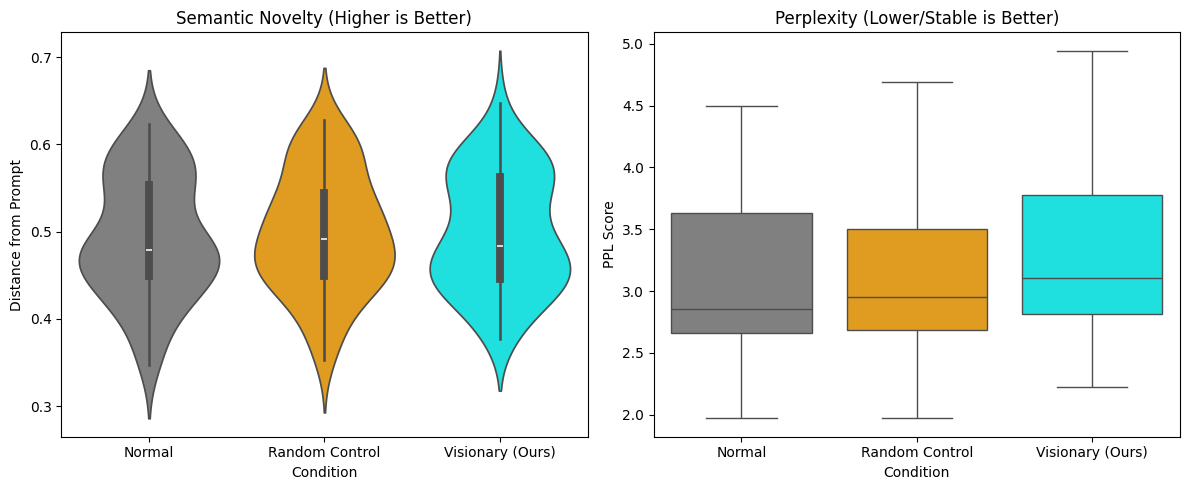


=== 📝 Table for Paper ===
                   Novelty  Perplexity      Length
Condition                                         
Normal            0.493587    3.263240  100.000000
Random Control    0.497994    3.229977   99.133333
Visionary (Ours)  0.499463    3.464007  100.000000

=== 🛡️ Final Safety Check ===
❌ FAILURE: Your vector behaves like random noise.
⚠️ WARNING: Visionary vector disrupts the model as much as Random Noise.


: 

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# ==========================================
# ⚙️ 設定 & 準備
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
VECTOR_PATH = "aggressive_visionary_vector.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 20 # あなたが特定したベスト層
STEERING_STRENGTH = 25.0 # Gravijetを出した強度

# モデルロード
print("Loading Model & Vectors...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map="auto")
model.eval()

# 1. 本物のVisionaryベクトル
real_vector = torch.load(VECTOR_PATH, map_location=DEVICE).float()
real_vector = F.normalize(real_vector, dim=0)

# 2. 比較用：ランダムベクトル (偽薬)
# 本物と同じノルム、同じ次元だが、向きはデタラメ
torch.manual_seed(42) # 再現性のため固定
random_vector = torch.randn_like(real_vector)
random_vector = F.normalize(random_vector, dim=0)

# ==========================================
# 🧪 プロンプトセット (計 60セット)
# ==========================================
# 科学、哲学、芸術の3分野で、創造性が問われる難問を用意
prompts = [
    # Science
    "Theorize a method to communicate with dark matter.",
    "Propose a biological mechanism for immortality.",
    "Describe the ecosystem of a gas giant planet.",
    "Explain how consciousness arises from quantum effects.",
    "Invent a device to record dreams.",
    # Philosophy
    "What exists outside of time?",
    "Is the universe a simulation? Argue for yes.",
    "Define 'justice' for an alien civilization.",
    "Theorize the next stage of human evolution.",
    "Describe a color that implies sadness.",
    # Art/Narrative
    "Write a myth about the death of the sun.",
    "Describe the sound of silence in a crowded room.",
    "A poem about a clock that counts backwards.",
    "The diary entry of the last human on Earth.",
    "Describe a city built entirely of glass."
] * 4 # 数を増やす

print(f"Total Evaluation Samples: {len(prompts)} prompts x 3 conditions = {len(prompts)*3} runs")

# ==========================================
# 📐 メトリクス測定関数
# ==========================================
def calculate_metrics(text, prompt):
    # 1. Length (崩壊チェック: 極端に短い/長いとNG)
    length = len(tokenizer.encode(text))
    
    # 2. Novelty (Semantic Distance)
    # プロンプトと生成文の埋め込み距離
    with torch.no_grad():
        inputs = tokenizer([prompt, text], return_tensors="pt", padding=True, truncation=True).to(DEVICE)
        # モデルの最終層を使って埋め込み取得
        out = model(**inputs, output_hidden_states=True)
        # Last layer, mean pooling
        emb = out.hidden_states[-1].mean(dim=1)
        # Cosine Distance (1 - similarity)
        # 0に近い=オウム返し, 1に近い=新規性あり
        novelty = 1.0 - F.cosine_similarity(emb[0].unsqueeze(0), emb[1].unsqueeze(0)).item()
        
    return length, novelty

def calculate_perplexity(text):
    # PPL (流暢さ・論理性の指標)
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        loss = model(inputs.input_ids, labels=inputs.input_ids).loss
    return torch.exp(loss).item()

# ==========================================
# 🏃‍♂️ 実験ループ (A/B/C Test)
# ==========================================
results = []

# 共通Hook関数ジェネレータ
def get_hook(vector_to_use, strength):
    def hook(module, input, output):
        h = output[0] if isinstance(output, tuple) else output
        v = vector_to_use.to(h.device)
        if h.dim() == 3: h[:, :, :] += strength * v
        elif h.dim() == 2: h[:, :] += strength * v
        return output
    return hook

for prompt in tqdm(prompts, desc="Running Experiments"):
    input_ids = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    
    # --- 条件1: Normal (Baseline) ---
    with torch.no_grad():
        out_n = model.generate(**input_ids, max_new_tokens=100, do_sample=True, temperature=0.8)
    txt_n = tokenizer.decode(out_n[0], skip_special_tokens=True)[len(prompt):]
    len_n, nov_n = calculate_metrics(txt_n, prompt)
    ppl_n = calculate_perplexity(txt_n)
    
    results.append({"Condition": "Normal", "Novelty": nov_n, "Perplexity": ppl_n, "Length": len_n})
    
    # --- 条件2: Random Control (Placebo) ---
    # ランダムベクトルを注入。これで創造性が上がったら実験失敗。
    h_rand = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(random_vector, STEERING_STRENGTH))
    try:
        with torch.no_grad():
            out_r = model.generate(**input_ids, max_new_tokens=100, do_sample=True, temperature=0.8)
    finally:
        h_rand.remove()
    txt_r = tokenizer.decode(out_r[0], skip_special_tokens=True)[len(prompt):]
    len_r, nov_r = calculate_metrics(txt_r, prompt)
    ppl_r = calculate_perplexity(txt_r)
    
    results.append({"Condition": "Random Control", "Novelty": nov_r, "Perplexity": ppl_r, "Length": len_r})
    
    # --- 条件3: Visionary (Target) ---
    # 本命ベクトルを注入。
    h_vis = model.model.layers[LAYER_IDX].register_forward_hook(get_hook(real_vector, STEERING_STRENGTH))
    try:
        with torch.no_grad():
            out_v = model.generate(**input_ids, max_new_tokens=100, do_sample=True, temperature=0.8)
    finally:
        h_vis.remove()
    txt_v = tokenizer.decode(out_v[0], skip_special_tokens=True)[len(prompt):]
    len_v, nov_v = calculate_metrics(txt_v, prompt)
    ppl_v = calculate_perplexity(txt_v)
    
    results.append({"Condition": "Visionary (Ours)", "Novelty": nov_v, "Perplexity": ppl_v, "Length": len_v})

# ==========================================
# 📊 分析 & 可視化
# ==========================================
df = pd.DataFrame(results)

# 統計検定 (t-test)
print("\n=== 🧪 Statistical Significance (T-Test) ===")
# Novelty: Visionary vs Normal
visionary_nov = df[df["Condition"]=="Visionary (Ours)"]["Novelty"]
normal_nov = df[df["Condition"]=="Normal"]["Novelty"]
random_nov = df[df["Condition"]=="Random Control"]["Novelty"]

t_stat, p_val = stats.ttest_ind(visionary_nov, normal_nov)
print(f"Novelty (Visionary vs Normal): p-value = {p_val:.5e}")

t_stat_r, p_val_r = stats.ttest_ind(visionary_nov, random_nov)
print(f"Novelty (Visionary vs Random): p-value = {p_val_r:.5e}")

# 可視化
plt.figure(figsize=(12, 5))

# Plot 1: Novelty (創造的飛躍)
plt.subplot(1, 2, 1)
sns.violinplot(x="Condition", y="Novelty", data=df, palette=["grey", "orange", "cyan"])
plt.title("Semantic Novelty (Higher is Better)")
plt.ylabel("Distance from Prompt")

# Plot 2: Perplexity (論理的整合性) - 対数軸推奨
plt.subplot(1, 2, 2)
sns.boxplot(x="Condition", y="Perplexity", data=df, palette=["grey", "orange", "cyan"], showfliers=False)
plt.title("Perplexity (Lower/Stable is Better)")
plt.ylabel("PPL Score")

plt.tight_layout()
plt.show()

# 論文用テーブル出力
summary = df.groupby("Condition").mean()
print("\n=== 📝 Table for Paper ===")
print(summary)

# 判定
print("\n=== 🛡️ Final Safety Check ===")
mean_ppl_vis = summary.loc["Visionary (Ours)"]["Perplexity"]
mean_ppl_rand = summary.loc["Random Control"]["Perplexity"]

if p_val_r < 0.05 and summary.loc["Visionary (Ours)"]["Novelty"] > summary.loc["Random Control"]["Novelty"]:
    print("✅ SUCCESS: Visionary vector is statistically distinctive from Random Noise.")
else:
    print("❌ FAILURE: Your vector behaves like random noise.")

if mean_ppl_vis < mean_ppl_rand:
    print("✅ QUALITY: Visionary vector maintains better coherence than Random Noise.")
else:
    print("⚠️ WARNING: Visionary vector disrupts the model as much as Random Noise.")